In [1]:
# ===============================
# 1) Setup & Load Data
# ===============================
# If running in Google Colab, uncomment the upload utility to upload your CSV.
# from google.colab import files
# uploaded = files.upload()  # then choose CAR DETAILS FROM CAR DEKHO.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Load dataset
FILE = "CAR DETAILS FROM CAR DEKHO.csv"
assert os.path.exists(FILE), f"Place {FILE} in working directory or upload it."
df = pd.read_csv(FILE)
print("Loaded:", df.shape)
df.head()


Loaded: (4340, 8)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [2]:
# Quick look at columns & dtypes
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,4340,1491,Maruti Swift Dzire VDI,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,4340.0,NaN,NaN,NaN,2013.090783,4.215344,1992.0,2011.0,2014.0,2016.0,2020.0
selling_price,4340.0,NaN,NaN,NaN,504127.311751,578548.736139,20000.0,208749.75,350000.0,600000.0,8900000.0
km_driven,4340.0,NaN,NaN,NaN,66215.777419,46644.102194,1.0,35000.0,60000.0,90000.0,806599.0
fuel,4340,5,Diesel,2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_type,4340,3,Individual,3244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,4340,2,Manual,3892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owner,4340,5,First Owner,2832,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nulls by column:
 name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

Duplicates: 763
              year  selling_price      km_driven
count  3577.000000   3.577000e+03    3577.000000
mean   2012.962538   4.739125e+05   69250.545709
std       4.251759   5.093018e+05   47579.940016
min    1992.000000   2.000000e+04       1.000000
25%    2010.000000   2.000000e+05   36000.000000
50%    2013.000000   3.500000e+05   60000.000000
75%    2016.000000   6.000000e+05   90000.000000
max    2020.000000   8.900000e+06  806599.000000
fuel : {'Diesel': 1800, 'Petrol': 1717, 'CNG': 37, 'LPG': 22, 'Electric': 1}
seller_type : {'Individual': 2832, 'Dealer': 712, 'Trustmark Dealer': 33}
transmission : {'Manual': 3265, 'Automatic': 312}
owner : {'First Owner': 2218, 'Second Owner': 978, 'Third Owner': 289, 'Fourth & Above Owner': 75, 'Test Drive Car': 17}


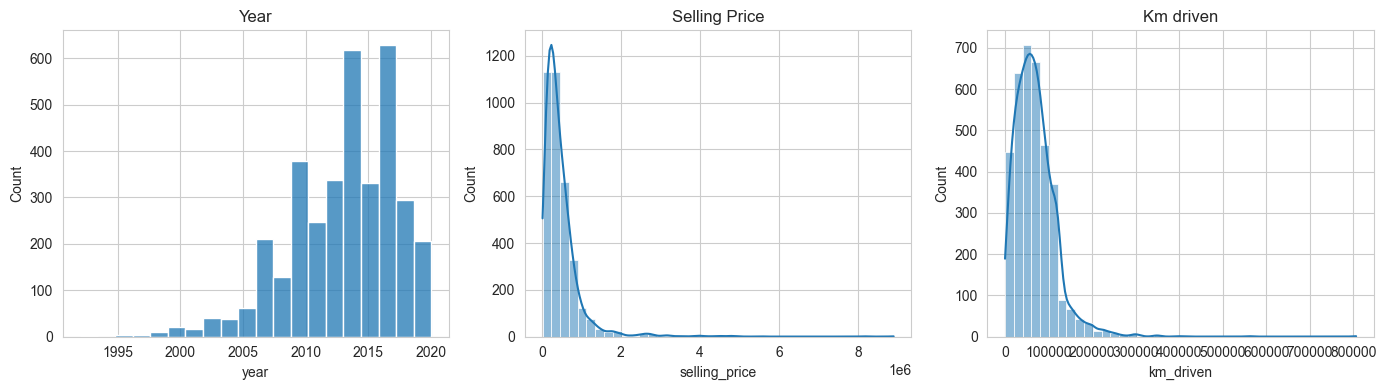

In [3]:
# ===============================
# 2) Quick EDA & Cleaning
# ===============================
# Basic checks
print("Nulls by column:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

# Drop duplicates (if any)
df = df.drop_duplicates().reset_index(drop=True)

# Inspect value ranges for numeric columns
print(df[['year','selling_price','km_driven']].describe())

# Check unique values for categorical features
for col in ['fuel','seller_type','transmission','owner']:
    print(col, ":", df[col].value_counts().to_dict())

# Visual quick plots
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(df['year'], bins=20)
plt.title('Year')

plt.subplot(1,3,2)
sns.histplot(df['selling_price'], bins=40, kde=True)
plt.title('Selling Price')

plt.subplot(1,3,3)
sns.histplot(df['km_driven'], bins=40, kde=True)
plt.title('Km driven')
plt.tight_layout()
plt.show()


In [4]:
# Identify obvious outliers (example: absurd km_driven or price)
print("max km:", df['km_driven'].max())
print("max price:", df['selling_price'].max())

# Optionally remove rows with extremely high km or price if they look erroneous.
# We'll not remove automatically but show how to cap with IQR if desired:
def cap_outliers(series, lower_q=0.01, upper_q=0.99):
    lower = series.quantile(lower_q)
    upper = series.quantile(upper_q)
    return series.clip(lower, upper)

# Example: cap selling_price and km_driven extremes for modeling stability (optional)
df['selling_price_cap'] = cap_outliers(df['selling_price'], 0.01, 0.99)
df['km_driven_cap'] = cap_outliers(df['km_driven'], 0.01, 0.99)


max km: 806599
max price: 8900000


In [5]:
# ===============================
# 3) Feature Engineering
# ===============================
# Extract brand from 'name' — first token typically brand
df['brand'] = df['name'].apply(lambda x: str(x).split()[0])

# Derive car age (assuming dataset year coverage up to 2020)
# Use a reference year (max year in dataset) to compute age so values are sensible
REF_YEAR = df['year'].max()
df['car_age'] = REF_YEAR - df['year']

# Simplify owner (optional): keep First, Second, Third, Fourth&Above, Test Drive
df['owner'] = df['owner'].str.strip()

# Use the capped price & km for modeling initially
df['target'] = df['selling_price_cap']
df = df.drop(columns=['selling_price'])  # keep original if you want as well


In [6]:
# Quick categories count
print("Brands:", df['brand'].nunique())
print(df['brand'].value_counts().nlargest(10))


Brands: 29
brand
Maruti        1072
Hyundai        637
Mahindra       328
Tata           308
Ford           220
Honda          216
Toyota         170
Chevrolet      151
Renault        110
Volkswagen      93
Name: count, dtype: int64


In [22]:
# ===============================
# 4) Preprocessing & Pipelines
# ===============================
# Features to use
num_features = ['km_driven_cap', 'car_age']
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'brand']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

# Create function to compute common metrics
def eval_regressor(model, X_train, X_test, y_train, y_test, cv=5):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'cv_r2_mean': cv_scores.mean(), 'cv_r2_std': cv_scores.std()}


In [23]:
# Prepare dataset for training
features = num_features + cat_features
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(2861, 7) (716, 7)


In [24]:
!pip install --upgrade scikit-learn


In [25]:
# ===============================
# 5) Baseline Models
# ===============================
# We'll evaluate a few baseline models using pipelines (preprocessor + model)

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, estimator in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    print("Training & evaluating:", name)
    res = eval_regressor(pipe, X_train, X_test, y_train, y_test)
    results[name] = res
    print(name, res)
    
# Display results nicely
pd.DataFrame(results).T.sort_values('rmse')


Training & evaluating: LinearRegression
LinearRegression {'rmse': 232860.49495124028, 'mae': 157501.30954822106, 'r2': 0.6802040217750327, 'cv_r2_mean': np.float64(0.6949769846469117), 'cv_r2_std': np.float64(0.045219215705238576)}
Training & evaluating: Ridge
Ridge {'rmse': 233487.08401423012, 'mae': 158336.83633030398, 'r2': 0.6784806701349042, 'cv_r2_mean': np.float64(0.6938668872855642), 'cv_r2_std': np.float64(0.04194942690496232)}
Training & evaluating: RandomForest
RandomForest {'rmse': 224890.12784759028, 'mae': 138082.28416371255, 'r2': 0.701721364335088, 'cv_r2_mean': np.float64(0.7277873264196413), 'cv_r2_std': np.float64(0.036396407777710055)}
Training & evaluating: GradientBoosting
GradientBoosting {'rmse': 208371.0738174199, 'mae': 136423.38276231466, 'r2': 0.7439314602333741, 'cv_r2_mean': np.float64(0.7522934678985285), 'cv_r2_std': np.float64(0.03808915494236897)}


,rmse,mae,r2,cv_r2_mean,cv_r2_std
GradientBoosting,208371.073817,136423.382762,0.743931,0.752293,0.038089
RandomForest,224890.127848,138082.284164,0.701721,0.727787,0.036396
LinearRegression,232860.494951,157501.309548,0.680204,0.694977,0.045219
Ridge,233487.084014,158336.836330,0.678481,0.693867,0.041949


In [26]:
# ===============================
# 6) Hyperparameter Tuning (Randomized Search for RandomForest)
# ===============================
# Tune RandomForest as an example; similar approach for GradientBoosting or XGBoost
param_dist = {
    'estimator__n_estimators': [100, 200, 400],
    'estimator__max_depth': [6, 10, 15, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__max_features': ['auto', 'sqrt', 0.8]
}

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', RandomForestRegressor(random_state=42, n_jobs=-1))])

rs = RandomizedSearchCV(
    rf_pipe, param_distributions=param_dist, 
    n_iter=20, cv=3, scoring='neg_root_mean_squared_error', 
    random_state=42, verbose=1, n_jobs=-1
)
rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
best_rf = rs.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 15}


In [29]:
# Evaluate tuned model on test set
y_pred = best_rf.predict(X_test)
print("Test RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test R2:", r2_score(y_test, y_pred))


Test RMSE: 212707.9210856159
Test MAE: 135241.33725264724
Test R2: 0.7331613767264546


In [30]:
# Cross-validate tuned model for stability
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2')
print("CV R2 mean:", cv_scores.mean(), "std:", cv_scores.std())


CV R2 mean: 0.7384692663011385 std: 0.03004504705621473


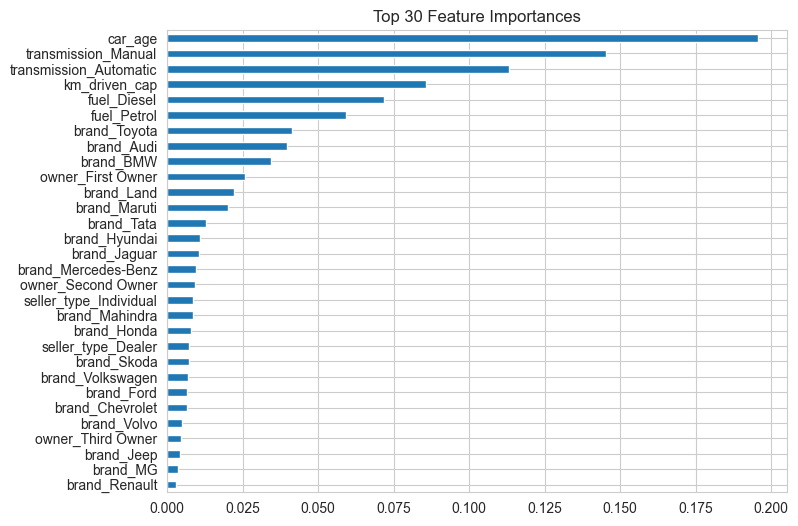

In [31]:
# ===============================
# 7) Feature Importance & Interpretation
# ===============================
# For tree models we can inspect feature importance. Need column names after one-hot
preprocessor.fit(X_train)
# Get transformed feature names (works for OneHotEncoder with get_feature_names_out)
num_cols_after = num_features
cat_cols_after = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features).tolist()
feature_names = num_cols_after + cat_cols_after

# If the best model is RandomForest in pipeline:
estimator = best_rf.named_steps['estimator']
importances = estimator.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
plt.figure(figsize=(8,6))
fi.plot(kind='barh')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


In [32]:
# Partial dependence / SHAP (optional) - if you want deeper interpretation:
# pip install shap
# import shap
# explainer = shap.TreeExplainer(best_rf.named_steps['estimator'])
# X_train_transformed = best_rf.named_steps['preprocessor'].transform(X_train)
# shap_values = explainer.shap_values(X_train_transformed)
# shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

# (Note: SHAP can be heavy; run on a sample)


In [35]:
# ===============================
# 8) Save Model & Next Steps
# ===============================
# Save the full pipeline

# ===============================
# 8) Save Model & Next Steps (with Pickle)
# ===============================
import pickle

MODEL_PATH = "car_price_rf_pipeline.pkl"

# Save the full pipeline
with open(MODEL_PATH, "wb") as f:
    pickle.dump(best_rf, f)

print("Saved model to", MODEL_PATH)

# Example of loading and predicting:
# with open(MODEL_PATH, "rb") as f:
#     loaded_model = pickle.load(f)
# sample = X_test.iloc[:3]
# preds = loaded_model.predict(sample)
# print(preds)


Saved model to car_price_rf_pipeline.pkl


In [37]:
import pickle
import pandas as pd

# Load the model
with open("car_price_rf_pipeline.pkl", "rb") as f:
    model = pickle.load(f)

# Example: Predict using first 3 rows of your test data
# (Make sure to load the same data format as training)
sample = X_test.iloc[:3]
predictions = model.predict(sample)
print("Predicted Prices:", predictions)


Predicted Prices: [ 481218.94148945  418569.35317439 1023037.09667179]
